## Exploratory Data Analysis (EDA) & Baseline Establishment

### Objective
The primary objective of this notebook is to establish a robust **statistical baseline** for the Pima Indians Diabetes dataset. Before simulating population drift, we must strictly define what "normal" data looks like. This process involves:
1.  **Structural Cleaning:** Identifying and handling errors (e.g., impossible zero-values in biological features).
2.  **Imputation Strategy:** Imputing missing values while preserving the signal of "missingness."
3.  **Distributional Profiling:** Quantifying the natural relationships and correlations between features.

#### Relevance to Drift Detection
This step serves as the foundation for the entire dissertation. To detect deviation (drift) in later experiments, we must first have a mathematically precise definition of normality:
* **Missingness as Signal:** We treat missing values not as errors to be deleted, but as potential signals of data quality drift.
* **Feature Selection:** By identifying which features (e.g., *Glucose*, *BMI*) strongly differentiate diabetic patients, we select the most impactful targets for our simulated drift experiments.

#### Data Loading & Basic Cleaning

#### Objective
The goal of this step is to:
- Load the Pima Indians Diabetes dataset from a local CSV file.  
- Inspect its structure, data types, and summary statistics.  
- Check for missing values and biologically impossible values (e.g., zero blood pressure).  
- Identify which features may need further cleaning or imputation in the next step.


In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from math import ceil
from scipy.stats import ttest_ind, ks_2samp

# Opt-in to the future behavior to silence the warning
pd.set_option('future.no_silent_downcasting', True)

# Loading dataset 
interim = Path("data/interim")
interim.mkdir(parents=True, exist_ok=True)
data_path = "../data/diabetes.csv"
pima = pd.read_csv(data_path)

# Quick checks
print("Shape:", pima.shape)
print("Columns:", pima.columns.tolist())


Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [2]:
# Display few initial entries
pima.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Preview Data Types and Non-Null Counts
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Summary Statistics (Central Tendency & Spread)
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
pima.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Quantifying Hidden Missing Values

**Objective:**
To identify and count "impossible zeros" in biological features. In the PIMA dataset, a value of 0 for attributes like `Glucose`, `BloodPressure`, or `BMI` indicates a missing measurement rather than a valid medical reading.

**Methodology:**
We filter the dataset for specific columns (`zero_cols`) where zero values are biologically impossible. We then aggregate the count of these zero entries to assess the extent of missing data prior to imputation.

In [6]:
# List of biological features where '0' indicates missing data (impossible in reality)
zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Create a boolean mask for zeros, sum the True values, and format as a DataFrame
zero_counts = (pima[zero_cols] == 0).sum().to_frame("zero_count")

# Render the table to inspect the count of hidden missing values
display(zero_counts)

,zero_count
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


#### **Preserving the "Clean State" Artifact**

**Objective:**
To serialize the "Clean but Unimputed" dataset to disk. This specific file (`pima_step1_clean.csv`) serves as the foundational artifact for all subsequent pipelines in this dissertation.

**Critical Note on Pipeline Integrity:**
At this stage, we have structurally corrected the data (replacing impossible zeros with `NaN`) but have **not yet imputed** the missing values.
* **Why pause here?** Imputation strategies (e.g., median vs. KNN) are model-dependent decisions. By saving the data in this raw, corrected state, we ensure that every drift experiment starts from the exact same "ground truth," allowing for fair, reproducible comparisons between the OCSVM and Isolation Forest pipelines.

In [7]:
# Create a working copy to preserve the original raw data structure
clean = pima.copy()

# Replace 0s with NaN in the identified biological columns to formally mark them as missing
clean[zero_cols] = clean[zero_cols].replace(0, pd.NA)

# Save the intermediate dataset to the interim directory
out_path = interim / "pima_step1_clean.csv"
clean.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data\interim\pima_step1_clean.csv


#### Handling Missing Values (Pima)

#### Objective
To address missing values in the Pima dataset in a way that preserves information about missingness, which may itself signal population drift.

#### Why this step matters
- Medical datasets often encode “not measured” values as `0`. After Step 1, we replaced these with `NaN`.  
- Simply imputing can hide important signals. For drift detection, *missingness patterns themselves* may change over time.  
- Therefore, we:
  1. Add binary flags (`*_is_missing`) to preserve missingness information.  
  2. Use median imputation for simplicity and robustness.
     
 Median imputation was chosen over other methods like mean imputation because it is less sensitive to outliers and provides a more robust estimate for  missing values. The missingness indicators will be used to monitor changes in missingness patterns over time, which could be indicative of population  drift.


In [8]:
# Reload the clean dataset 
clean = pd.read_csv(interim / "pima_step1_clean.csv")
print("Shape:", clean.shape)
print("Missing values before handling:\n", clean.isnull().sum())

Shape: (768, 9)
Missing values before handling:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [9]:
# Add missingness indicator columns
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zero:
    # Generate binary flags (0/1) to capture the pattern of missingness as a predictive signal
    clean[f"{col}_is_missing"] = clean[col].isna().astype(int)

# Median imputation
imputed = clean.copy()
# Fill NaNs with the median to create a complete dataset; chosen for robustness against skew/outliers
imputed[cols_with_zero] = imputed[cols_with_zero].fillna(imputed[cols_with_zero].median())

# Audit the final dataframe to confirm no missing values remain
print("\nMissing values after imputation:\n", imputed.isnull().sum())

# Save the imputed artifact (Step 2) strictly for EDA and visualization purposes
out_path = interim / "pima_step2_imputed.csv"
imputed.to_csv(out_path, index=False)
print("Saved:", out_path)



Missing values after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Glucose_is_missing          0
BloodPressure_is_missing    0
SkinThickness_is_missing    0
Insulin_is_missing          0
BMI_is_missing              0
dtype: int64
Saved: data\interim\pima_step2_imputed.csv


In [10]:
# Displaying few initial entires
imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_is_missing,BloodPressure_is_missing,SkinThickness_is_missing,Insulin_is_missing,BMI_is_missing
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,0,0,0,1,0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,0,0,0,1,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,0,0,1,1,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,0,0,0,0


### Reproducibility Setup (Artifact Management)

**Objective**
To define helper functions for saving figures and tables automatically. This ensures that the outputs of our EDA (like the correlation heatmap and distribution plots) are systematically organized and preserved without manual file handling.

In [11]:
# Define the project root directory
PROJECT = Path(".")
# Create a 'drafts' directory to store all experimental runs; create parents if missing
DRAFTS = PROJECT/"reports"/"drafts"; DRAFTS.mkdir(parents=True, exist_ok=True)

# name each run once per session to distinguish experiments
RUN_TAG = "eda-pima"  # change per notebook/task: e.g., "iforest-grid", "ocsvm-baseline"

# Create a unique, timestamped directory for this specific run to avoid overwriting previous results
RUN_DIR = DRAFTS / f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{RUN_TAG}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Create sub-directories for organizing figures and tables within this run
FIGS = RUN_DIR / "figs"; FIGS.mkdir(exist_ok=True)
TABLES = RUN_DIR / "tables"; TABLES.mkdir(exist_ok=True)

# Helper function to save matplotlib figures to the run's 'figs' folder
def save_fig(name):  # no extensions in name
    import matplotlib.pyplot as plt
    # Construct the full path
    p = FIGS / f"{name}.png"
    # Save with high DPI and tight bounding box for report-ready quality
    plt.savefig(p, dpi=150, bbox_inches="tight")
    print("saved fig ->", p)

# Helper function to save pandas DataFrames to the run's 'tables' folder
def save_table(df, name):
    # Construct the full path with .csv extension
    p = TABLES / f"{name}.csv"
    # Save without the index to keep the CSV clean
    df.to_csv(p, index=False)
    print("saved table ->", p)

### Univariate Distribution Analysis

#### Objective & Methodology
To characterize the baseline probability density function $P(X)$ for all continuous features. We profile each predictor via:
1.  **Statistical Moments:** Calculating Mean, Standard Deviation, and Skewness to quantify central tendency and asymmetry.
2.  **Visual Profiling:** Generating Histograms (using **Freedman-Diaconis** adaptive binning) overlaid with Kernel Density Estimation (KDE) to map the feature's natural shape.

#### Relevance to Drift
This establishes the "normality" baseline against which **simulated drift** will be measured. It also identifies heavy tails (e.g., in *Insulin*), validating the need for robust preprocessing (e.g., Log-scaling) to ensure OCSVM/IF stability.

In [12]:
# paths
IMPUTED_PATH = Path("data/interim/pima_step2_imputed.csv")
imputed = pd.read_csv(IMPUTED_PATH)

# select numeric features (exclude Outcome and *_is_missing flags)
all_num = imputed.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in all_num if c != "Outcome" and not c.endswith("_is_missing")]

print("Features to profile:", feature_cols)

# compact summary table (rounded for readability)
summary = imputed[feature_cols].agg(["count","mean","std","min","max","skew"]).T.round(3)
summary = summary.rename_axis("feature").reset_index()

display(summary)

# (optional) save the table to drafts
save_table(summary, "univariate_summary_pima")
print("Saved -> reports/tables/univariate_summary_pima.csv")


Features to profile: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,feature,count,mean,std,min,max,skew
0,Pregnancies,768.0,3.845,3.370,0.000,17.00,0.902
1,Glucose,768.0,121.656,30.438,44.000,199.00,0.536
2,BloodPressure,768.0,72.387,12.097,24.000,122.00,0.142
3,SkinThickness,768.0,29.108,8.791,7.000,99.00,0.838
4,Insulin,768.0,140.672,86.383,14.000,846.00,3.380
5,BMI,768.0,32.455,6.875,18.200,67.10,0.599
6,DiabetesPedigreeFunction,768.0,0.472,0.331,0.078,2.42,1.920
7,Age,768.0,33.241,11.760,21.000,81.00,1.130


saved table -> reports\drafts\20260114_165912_eda-pima\tables\univariate_summary_pima.csv
Saved -> reports/tables/univariate_summary_pima.csv


saved fig -> reports\drafts\20260114_165912_eda-pima\figs\univariate_panels_pima.png
Saved -> reports/figures/univariate_panels_pima.png


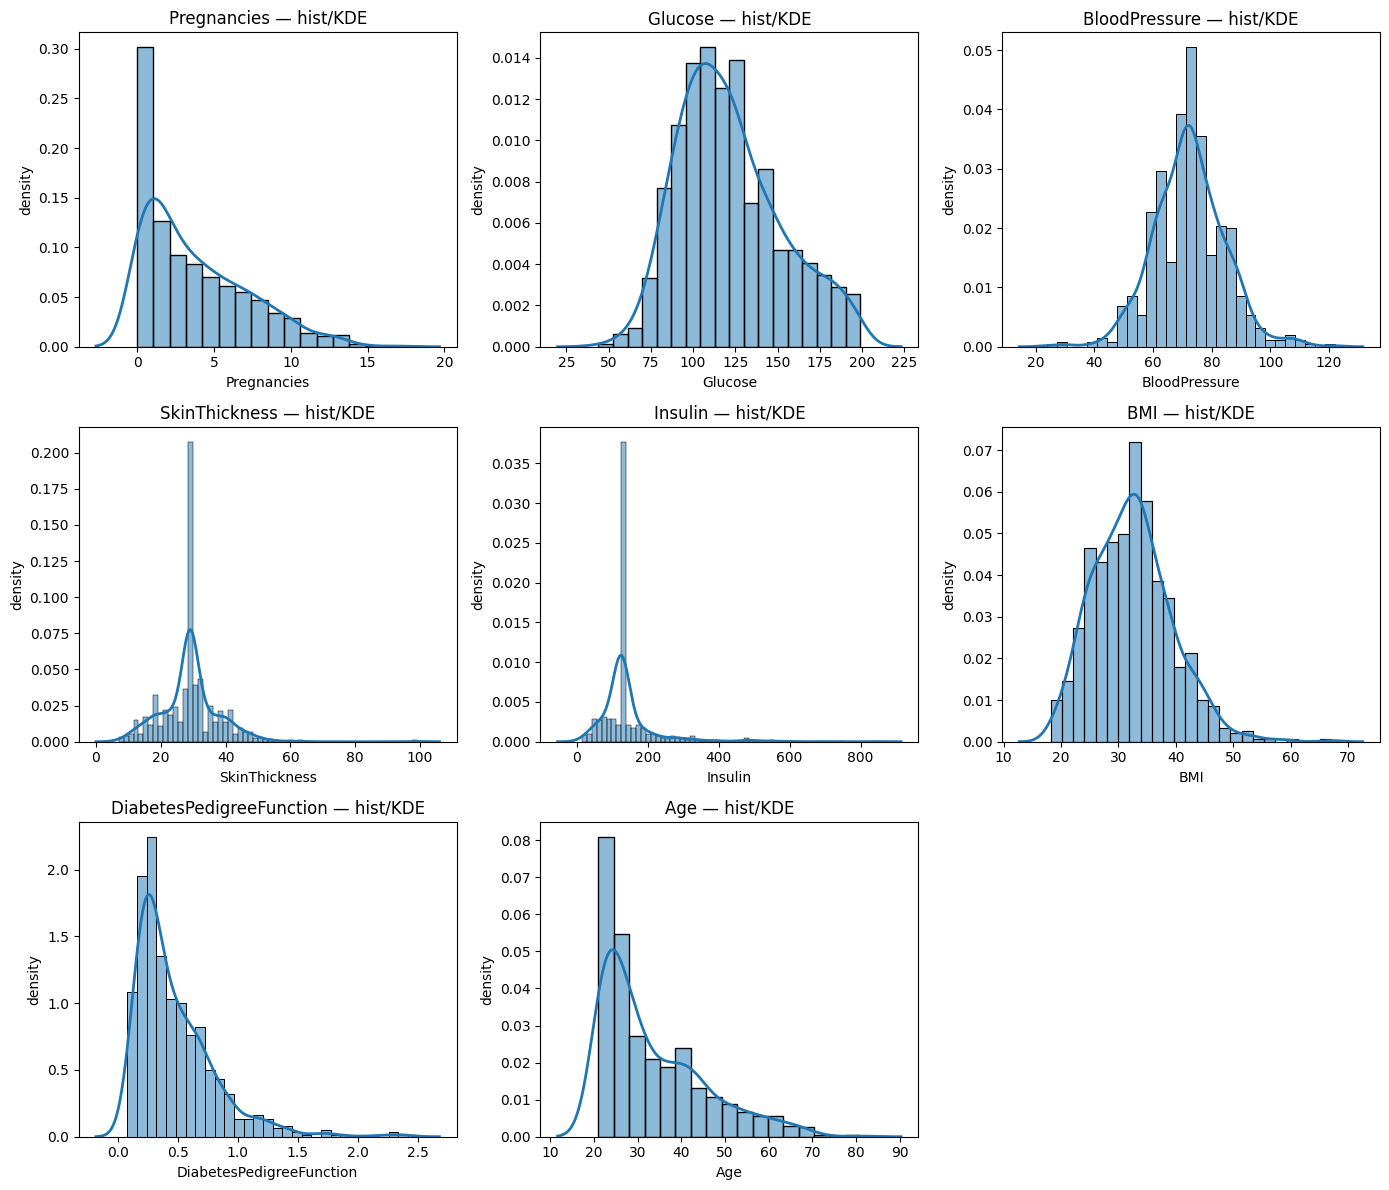

In [13]:
# Helper: Freedman-Diaconis rule for adaptive binning
def fd_bins(x):
    x = np.asarray(x.dropna())
    if x.size < 2:
        return 10  # Fallback for empty/single-value features
    
    # Calculate Interquartile Range (IQR) = 75th percentile - 25th percentile
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    # If variance is zero (all values are the same), return default to avoid division by zero
    if iqr == 0:
        return 10
    
    # The FD Formula: h = 2 * IQR * n^(-1/3)
    h = 2 * iqr * (x.size ** (-1/3))
    
    # Calculate bin count: Range / Bin_Width
    # Clip between 10 and 60 to keep plots readable (prevents 1000+ tiny bins)
    bins = int(np.clip(np.ceil((x.max() - x.min()) / h), 10, 60))
    return bins

# Plotting Setup: Create a dynamic grid (3 columns) based on feature count
n = len(feature_cols)
ncols = 3
nrows = ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.ravel()  # Flatten the 2D grid into a 1D array for easy iteration

for i, col in enumerate(feature_cols):
    ax = axes[i]
    data = imputed[col].dropna()
    
    # Dynamically calculate bins for this specific feature
    bins = fd_bins(data)

    # Plot Histogram: Use 'stat="density"' so the area sums to 1 (matching the KDE scale)
    sns.histplot(data, bins=bins, stat="density", alpha=0.5, ax=ax)
    
    # Plot KDE: The smooth probability density curve $P(X)$ overlay
    sns.kdeplot(data, ax=ax, lw=2)

    ax.set_title(f"{col} — hist/KDE")
    ax.set_xlabel(col)
    ax.set_ylabel("density")

# Cleanup: Hide any empty subplots if the number of features isn't a multiple of 3
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

# Save the artifact for the report
save_fig("univariate_panels_pima")
print("Saved -> reports/figures/univariate_panels_pima.png")

plt.show()

### Class Balance Check

#### Objective
To quantify the proportion of the minority class (Diabetic = 1) versus the majority class (Healthy = 0) in the baseline partition.

#### Relevance to Drift Detection (K-S & SHAP)
Although our detection framework is unsupervised (relying on **K-S Tests** and **Density Ratios**), understanding the class composition is critical for interpreting these metrics:
1.  **Baseline Mixture Definition:** The baseline distribution $P(X)$—which the K-S test uses as the "Ground Truth"—is a mixture of 65% healthy and 35% diabetic patterns. Documenting this ratio helps distinguish between genuine Feature Drift (changes in $P(X|y)$) and simple Class Imbalance shifts (changes in $P(y)$).
2.  **SHAP Sensitivity:** SHAP values calculate feature contributions relative to the "average" baseline instance. Since 35% of the baseline is diabetic, the "average" patient profile is skewed. Acknowledging this explains the model's sensitivity threshold when explaining drift.

Baseline Class Proportion:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64
saved fig -> reports\drafts\20260114_165912_eda-pima\figs\class_balance_pima.png


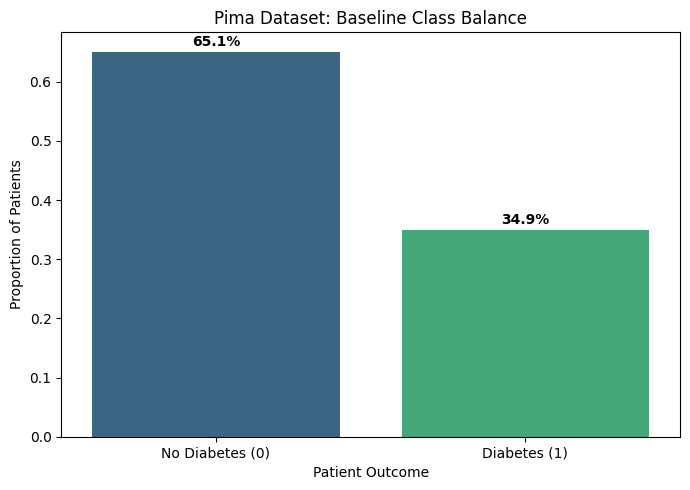

In [14]:
# Calculate and Print Class Balance
print("Baseline Class Proportion:")
class_balance = imputed['Outcome'].value_counts(normalize=True)
print(class_balance)

# Visualize the Class Balance (Warning-Free) 
fig, ax = plt.subplots(figsize=(7, 5))

# Modified the barplot call to prevent the FutureWarning
# Assigning 'x' to 'hue' and disabling the legend is the recommended practice
sns.barplot(x=class_balance.index, y=class_balance.values, ax=ax, palette='viridis',
            hue=class_balance.index, legend=False)

# Add plot titles and labels for clarity
ax.set_title('Pima Dataset: Baseline Class Balance')
ax.set_ylabel('Proportion of Patients')
ax.set_xlabel('Patient Outcome')

# Modified the tick label setting to prevent the UserWarning
# Explicitly set the ticks before setting their labels
ax.set_xticks(class_balance.index)
ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])

# Add percentage labels to the bars for easy interpretation
for index, value in enumerate(class_balance):
    ax.text(index, value + 0.01, f'{value:.1%}', ha='center', fontweight='bold')

plt.tight_layout()

# --- Save the Figure Using Your Helper Function ---
save_fig("class_balance_pima")

plt.show()

### Feature Correlation Heatmap

#### Objective & Methodology
To quantify the baseline **covariance structure** of the dataset. We compute the Pearson correlation coefficient for all feature pairs and visualize the matrix as a heatmap to identify strong linear dependencies (e.g., between *BMI* and *SkinThickness*).

#### Relevance to Drift Detection
This establishes the "relational ground truth" required to detect **Multivariate Drift**.
* **Covariance Shift:** Simple univariate tests (like the K-S test) only detect if a single feature changes. This heatmap defines the expected interactions, allowing us to later investigate if the *relationship* between features has degraded (e.g., if *Insulin* stops correlating with *Glucose*), even if their individual distributions remain stable.

saved fig -> reports\drafts\20260114_165912_eda-pima\figs\correlation_heatmap_pima.png


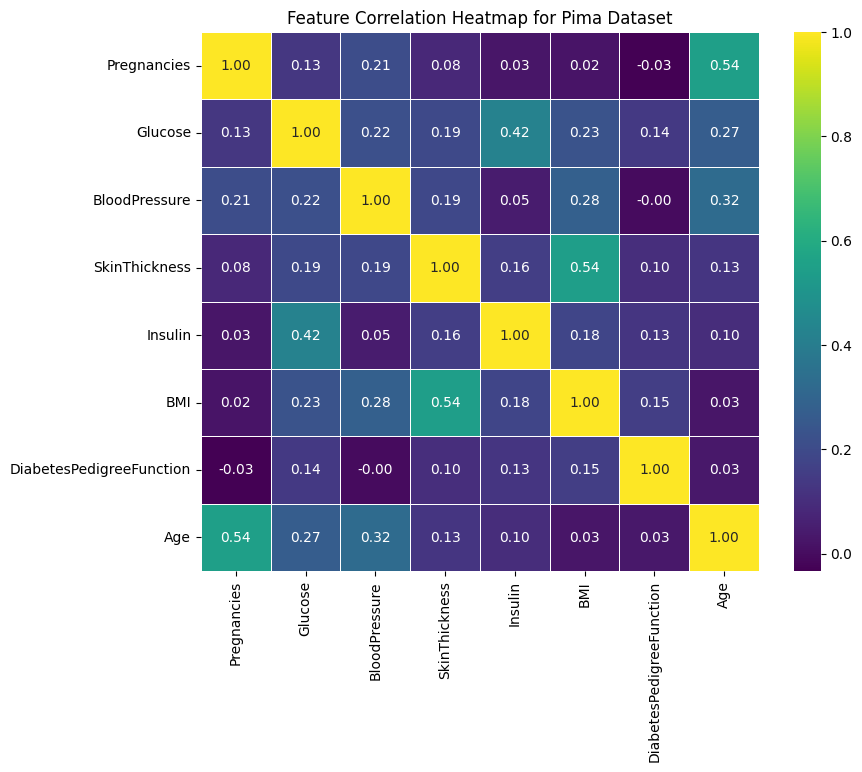

In [15]:
# Calculate the correlation matrix for the numerical features.
corr_matrix = imputed[feature_cols].corr()

# Set up the matplotlib figure.
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(corr_matrix, 
            annot=True,      # Write the data value in each cell
            fmt=".2f",       # Use two decimal places for annotations
            cmap='viridis',    # Use a visually appealing color map
            linewidths=.5)   # Add lines between cells

# Add a descriptive title.
plt.title('Feature Correlation Heatmap for Pima Dataset')

# Save the figure to the run-specific directory.
save_fig("correlation_heatmap_pima")

# Display the plot.
plt.show()

### Outlier Analysis (Box Plots)

#### Objective & Methodology
To visually inspect the distributional spread and detect extreme deviations (outliers) for each feature, conditioned on the target class (`Outcome`). We utilize **Box-and-Whisker plots** to visualize the Interquartile Range (IQR) and identify points lying beyond $1.5 \times IQR$ (displayed as individual points).

#### Relevance to Drift Detection
1.  **Simulation Constraints:** These plots define the "physiologically plausible" max/min boundaries. This empirical evidence justifies the clipping thresholds used in our drift simulations (Section 2.4) to ensure synthetic data remains realistic.
2.  **Baseline Noise Quantification:** OCSVM and Isolation Forest are sensitive to training set contamination. Identifying heavy outlier density in features like *Insulin* informs the need for robust preprocessing (e.g., RobustScaler) to prevent the baseline model from fitting to noise.

saved fig -> reports\drafts\20260114_165912_eda-pima\figs\boxplots_by_outcome_pima.png


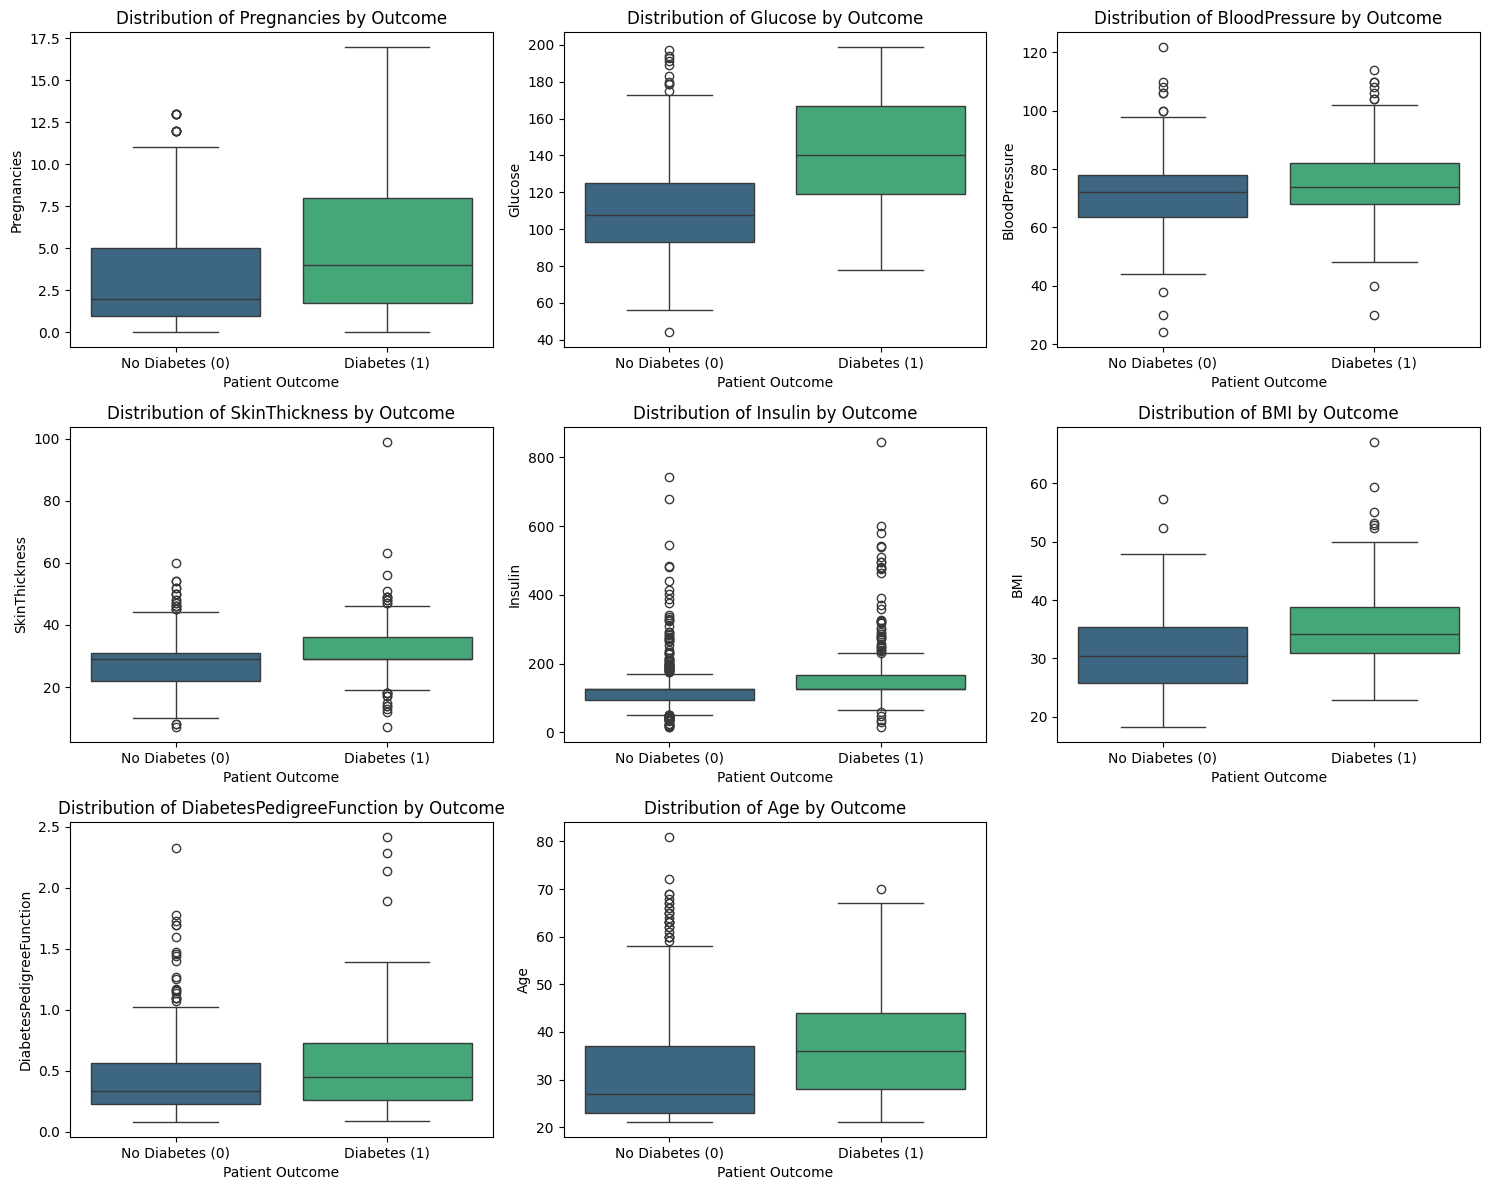

In [16]:
# Set up the plotting grid
n_features = len(feature_cols)
ncols = 3
nrows = ceil(n_features / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.ravel() 

# Create a box plot for each feature by Outcome 
for i, col in enumerate(feature_cols):
    ax = axes[i]
    
    # Modified the boxplot call to prevent the FutureWarning
    sns.boxplot(data=imputed, x='Outcome', y=col, ax=ax, palette='viridis',
                hue='Outcome', legend=False)
    
    # Add plot titles and labels
    ax.set_title(f'Distribution of {col} by Outcome')
    ax.set_xlabel('Patient Outcome')
    ax.set_ylabel(col)

    # Modified the tick label setting to prevent the UserWarning
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])

# Hide any unused subplots in the grid
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

# --- Save the Figure Using Your Helper Function ---
save_fig("boxplots_by_outcome_pima")

plt.show()

### Class-Conditional Statistics

#### Objective & Methodology
To quantify the statistical divergence between the sub-populations (Healthy vs. Diabetic). We utilize grouped descriptive statistics to calculate the central tendency (Mean) and dispersion (Std Dev) for each feature, conditioned on the target variable.

#### Relevance to Drift Simulation
1.  **Feature Prioritization:** This analysis identifies features with the largest statistical separation (e.g., *Glucose* shows a mean difference of ~30 units). These features are selected as the primary targets for **Drift Simulation** because shifting them represents the most biologically realistic and challenging scenario for the anomaly detectors.
2.  **Baseline Definition:** It precisely defines the "Normal" subspace (Outcome=0). Since OCSVM attempts to learn the boundary of this specific sub-population, these statistics serve as the ground truth parameters for the "normal" cluster.

In [17]:
# Calculate descriptive statistics for each feature, grouped by the 'Outcome' variable.
class_stats = imputed.groupby('Outcome')[feature_cols].describe()

# To make the table easier to read, you can transpose it.
display(class_stats.T)

# Save the table to the run-specific directory.
# Note: .describe() creates a multi-index DataFrame, which saves neatly to Excel or can be formatted for CSV.
save_table(class_stats.T.reset_index(), "class_conditional_summary")
# After your code for displaying class_stats.T, you can add this:
print("\nKey Mean Values:")
display(imputed.groupby('Outcome')[['Glucose', 'BMI']].mean())

Outcome                     0           1
Pregnancies count  500.000000  268.000000
            mean     3.298000    4.865672
            std      3.017185    3.741239
            min      0.000000    0.000000
            25%      1.000000    1.750000
...                       ...         ...
Age         min     21.000000   21.000000
            25%     23.000000   28.000000
            50%     27.000000   36.000000
            75%     37.000000   44.000000
            max     81.000000   70.000000

[64 rows x 2 columns]

saved table -> reports\drafts\20260114_165912_eda-pima\tables\class_conditional_summary.csv

Key Mean Values:


,Glucose,BMI
Outcome,,
0,110.682000,30.885600
1,142.130597,35.383582


### Statistical Significance Tests

#### Objective & Methodology
To rigorously validate the distributional divergence between the diabetic and non-diabetic sub-populations. We employ a dual-test approach for each feature:
1.  **Independent T-test:** Assesses differences in central tendency (Mean shift).
2.  **Kolmogorov-Smirnov (KS) Test:** Assesses differences in the overall shape of the cumulative distribution function (CDF).

#### Relevance to Drift Simulation
This analysis provides the **statistical justification** for feature selection in our drift experiments. Features with near-zero p-values (e.g., *Glucose*, *BMI*) exhibit the strongest separation between "Normal" and "Anomalous" states. Manipulating these features in later simulations therefore guarantees that we are modeling a **statistically significant** transition in patient physiology, rather than arbitrary noise.

In [18]:
# Separate the two groups for comparison
group0 = imputed[imputed['Outcome'] == 0]
group1 = imputed[imputed['Outcome'] == 1]

# Store test results
test_results = []

for col in feature_cols:
    # Perform T-test for the means
    t_stat, t_pvalue = ttest_ind(group0[col], group1[col])
    
    # Perform KS test for the distributions
    ks_stat, ks_pvalue = ks_2samp(group0[col], group1[col])
    
    test_results.append({
        'Feature': col,
        'T-statistic': t_stat,
        'T-test p-value': t_pvalue,
        'KS-statistic': ks_stat,
        'KS-test p-value': ks_pvalue
    })

# Create a DataFrame from the results for easy viewing
results_df = pd.DataFrame(test_results)

print("Statistical Significance Test Results (Feature vs. Outcome)")
display(results_df)

# Save the results table
save_table(results_df, "statistical_tests_summary")

Statistical Significance Test Results (Feature vs. Outcome)


,Feature,T-statistic,T-test p-value,KS-statistic,KS-test p-value
0,Pregnancies,-6.298431,5.065127e-10,0.206478,5.308990e-07
1,Glucose,-15.673795,3.128719e-48,0.433493,5.020536e-30
2,BloodPressure,-4.650976,3.890835e-06,0.164806,1.290114e-04
3,SkinThickness,-6.089215,1.793958e-09,0.197045,2.054236e-06
4,Insulin,-5.761145,1.210026e-08,0.223522,3.904146e-08
5,BMI,-9.090064,8.336903e-19,0.302090,1.417805e-14
6,DiabetesPedigreeFunction,-4.885826,1.254607e-06,0.170149,6.841012e-05
7,Age,-6.792688,2.209975e-11,0.327075,4.783018e-17


saved table -> reports\drafts\20260114_165912_eda-pima\tables\statistical_tests_summary.csv
